In [41]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define tickers
djia_ticker = "^DJI"
libor_ticker = "^IRX"  # Example for 13-week Treasury Bill rate as a proxy for 3-month LIBOR

# Download data
djia_data = yf.download(djia_ticker, start="2010-01-01", end="2022-01-01")
libor_data = yf.download(libor_ticker, start="2010-01-01", end="2022-01-01")

# Extract adjusted close prices
djia_prices = djia_data['Adj Close']
libor_rates = libor_data['Adj Close']

# Drop any missing values
djia_prices.dropna(inplace=True)
libor_rates.dropna(inplace=True)

# Calculate log returns for DJIA
djia_log_returns = np.log(djia_prices / djia_prices.shift(1)).dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [42]:
import yfinance as yf
import pandas as pd
import numpy as np


djia_ticker = "^DJI"
libor_ticker = "^IRX" 


djia_data = yf.download(djia_ticker, start="2010-01-01", end="2022-01-01")
libor_data = yf.download(libor_ticker, start="2010-01-01", end="2022-01-01")


djia_prices = djia_data['Adj Close']
libor_rates = libor_data['Adj Close']


djia_prices.dropna(inplace=True)
libor_rates.dropna(inplace=True)


djia_log_returns = np.log(djia_prices / djia_prices.shift(1)).dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [43]:
import numpy as np
mu = djia_log_returns.mean()
sigma = djia_log_returns.std()

# GBM model function
def gbm_model(t, S0, mu, sigma, W):
    return S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

# Vasicek model function
def vasicek_model(t, r0, a, b, sigma, W):
    return b + (r0 - b) * np.exp(-a * t) + sigma1 * np.exp(-a * t) * W

In [44]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares


libor_log_returns = np.log(libor_rates / libor_rates.shift(1)).dropna()

# Define time step (in years)
tau = 1.0

# Calculate mean, min, and max of historical rates
r_mean = libor_log_returns.mean()
r_min = libor_log_returns.min()
r_max = libor_log_returns.max()

# Objective function to minimize for parameter estimation
def vasicek_error(params, rates, dt):
    a1, b1, sigma0 = params
    n = len(rates)
    errors = []
    for i in range(1, n):
        r_prev = rates[i-1]
        r_curr = rates[i]
        dr = r_curr - r_prev
        model_dr = a1 * (b1 - r_prev) * dt
        error = dr - model_dr
        errors.append(error)
    return np.array(errors)


initial_guess = [0.1, 0.03, 0.005]

# Minimize the objective function using Levenberg-Marquardt (lm) method
dt = tau/len(libor_rates)
result = least_squares(vasicek_error, initial_guess, args=(libor_rates,dt), method='lm')


a, b, sigma1 = result.x

print(f"Estimated parameters using Levenberg-Marquardt algorithm (lm method):")
print(f"a: {a:.4f}")
print(f"b: {b:.4f}")
print(f"sigma: {sigma1:.4f}")


/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_60524/2399271329.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_prev = rates[i-1]
/tmp/ipykernel_60524/2399271329.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_curr = rates[i]


Estimated parameters using Levenberg-Marquardt algorithm (lm method):
a: 0.7788
b: 0.4649
sigma: 0.0050


In [45]:
import numpy as np
from scipy.optimize import least_squares

# Define the GBM model
def gbm_model(t, S0, mu, sigma, W):
    dt = t[1] - t[0]
    S = np.zeros(len(t))
    S[0] = S0
    for i in range(1, len(t)):
        S[i] = S[i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * W[i-1])
    return S

# Define the Vasicek model
def vasicek_model(t, r0, a, b, sigma1, W):
    dt = t[1] - t[0]
    r = np.zeros(len(t))
    r[0] = r0
    for i in range(1, len(t)):
        r[i] = r[i-1] + a * (b - r[i-1]) * dt + sigma1 * np.sqrt(dt) * W[i-1]
    return r

# Define residuals for GBM
def gbm_residuals(params, t, data):
    S0, mu, sigma = params
    W = np.random.standard_normal(len(t))
    model = gbm_model(t, S0, mu, sigma, W)
    return model[:len(data)] - data

# Define residuals for Vasicek
def vasicek_residuals(params, t, data):
    r0, a, b, sigma1 = params
    W = np.random.standard_normal(len(t))
    model = vasicek_model(t, r0, a, b, sigma1, W)
    return model[:len(data)] - data

# Initial guesses
mu_initial = np.mean(djia_log_returns)
sigma_initial = np.std(djia_log_returns)
gbm_initial_guess = [djia_prices.iloc[0], mu_initial, sigma_initial]

a_initial = 0.1
b_initial = np.mean(libor_rates)
sigma1_initial = np.std(libor_rates)
vasicek_initial_guess = [libor_rates.iloc[0], a_initial, b_initial, sigma1_initial]

# Calibration
t_gbm = np.arange(len(djia_log_returns))
t_vasicek = np.arange(len(libor_rates))

# Adding bounds to ensure the parameters stay within reasonable limits
gbm_bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])
vasicek_bounds = ([0, 0, -np.inf, 0], [np.inf, np.inf, np.inf, np.inf])

# Calibration with robust initial values and bounds
gbm_result = least_squares(gbm_residuals, gbm_initial_guess, args=(t_gbm, djia_log_returns.values), bounds=gbm_bounds)
vasicek_result = least_squares(vasicek_residuals, vasicek_initial_guess, args=(t_vasicek, libor_rates.values), bounds=vasicek_bounds)

# Extract parameters
gbm_params = gbm_result.x
vasicek_params = vasicek_result.x

print(f"GBM Parameters: S0={gbm_params[0]}, mu={gbm_params[1]}, sigma={gbm_params[2]}")
print(f"Vasicek Parameters: r0={vasicek_params[0]}, a={vasicek_params[1]}, b={vasicek_params[2]}, sigma={vasicek_params[3]}")


GBM Parameters: S0=10583.960010810162, mu=0.00040845258174752533, sigma=0.010771405939398866
Vasicek Parameters: r0=0.054999999701976776, a=0.1, b=0.4930367665897479, sigma=0.7393841126632912


In [46]:
# Simulate GBM
simulated_djia = gbm_model(t_gbm, *gbm_params, np.random.standard_normal(len(t_gbm)))

# Simulate Vasicek
simulated_libor = vasicek_model(t_vasicek, *vasicek_params, np.random.standard_normal(len(t_vasicek)))

In [47]:
def monte_carlo_option_pricing(num_simulations, t, S0, mu, sigma, r0, a, b, sigma_v, payoff_func):
    payoffs = []
    for _ in range(num_simulations):
        W_gbm = np.random.standard_normal(len(t))
        W_vasicek = np.random.standard_normal(len(t))
        
        simulated_djia = gbm_model(t, S0, mu, sigma, W_gbm)
        simulated_libor = vasicek_model(t, r0, a, b, sigma_v, W_vasicek)
        
        payoff = payoff_func(simulated_djia, simulated_libor)
        payoffs.append(payoff)
    
    return np.mean(payoffs), np.std(payoffs)

# Define payoff function
def option_payoff(djia, libor):
    growth_rate_djia = djia[-1] / djia[0]
    realized_libor = libor[-1]
    expected_libor = np.mean(libor)
    return growth_rate_djia * (realized_libor / expected_libor)

# Parameters for Monte Carlo
num_simulations = 10000
S0_djia = djia_prices.iloc[0]
t_simulation = np.linspace(0, 1, len(t_gbm))  # Assuming 1-year simulation period

# Calculate option price
option_price, option_price_std = monte_carlo_option_pricing(num_simulations, t_simulation, S0_djia, gbm_params[1], gbm_params[2], vasicek_params[0], vasicek_params[1], vasicek_params[2], vasicek_params[3], option_payoff)

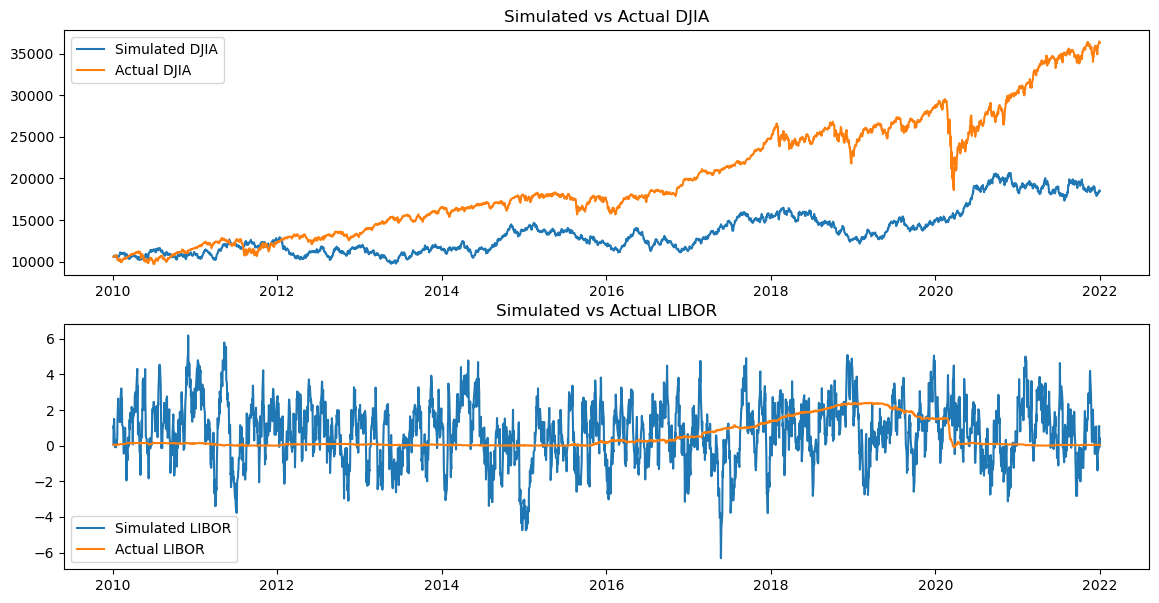

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot DJIA simulation
plt.subplot(2, 1, 1)
plt.plot(djia_prices.index[1:], simulated_djia, label="Simulated DJIA")
plt.plot(djia_prices.index, djia_prices, label="Actual DJIA")
plt.legend()
plt.title("Simulated vs Actual DJIA")

# Plot LIBOR simulation
plt.subplot(2, 1, 2)
plt.plot(libor_rates.index, simulated_libor, label="Simulated LIBOR")
plt.plot(libor_rates.index, libor_rates, label="Actual LIBOR")
plt.legend()
plt.title("Simulated vs Actual LIBOR")

plt.show()

In [49]:
option_price

4.711892869181978